In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

### Load the files we have & extract farms and dates

In [2]:
bbox = pd.read_csv("../data/all_farms/animal_facilities_bbox.csv")

files = pd.read_csv('../files.csv', header=None)[0].values
files = [f[len("gs://cs325b-animal-facilities/data/"):] for f in files if f.endswith(".tif")]

In [3]:
naip_dairy_all = [f[len("all_farms/naip/dairy/"): ] for f in files if f.startswith("all_farms/naip/dairy/")]
naip_poultry_all = [f[len("all_farms/naip/poultry/"): ] for f in files if f.startswith("all_farms/naip/poultry/")]
naip_top20 = [f[len("top_20/naip/"): ] for f in files if f.startswith("top_20/naip/")]
ps_top20 = [f[len("top_20/psscenes/"): ] for f in files 
            if f.startswith("top_20/psscenes/") and f.endswith("_AnalyticMS_SR_clip_reproject.tif")]
# don't need to get udm data too

In [4]:
def parse_naip_filename(filename): 
    farm_idx = filename.split("_")[0]
    mm = int(filename.split("_")[1])
    dd = int(filename.split("_")[2])
    yy = 2000 + int(filename.split("_")[3][:2])
    return farm_idx, datetime(yy, mm, dd)

def parse_pss_filename(filename): 
    farm_idx = filename.split("_")[0]
    date = filename.split("/")[1][:8]
    yy = int(date[:4])
    mm = int(date[4:6])
    dd = int(date[6:])
    return farm_idx, datetime(yy, mm, dd)

def get_idx_date_dict(filenames, data_source="naip"):
    idx_date_dict = {}
    for f in filenames:
        if data_source == "naip":
            idx, date = parse_naip_filename(f)
        elif data_source == "pss":
            idx, date = parse_pss_filename(f)
        if idx not in idx_date_dict:
            idx_date_dict[idx] = []
        idx_date_dict[idx].append(date)

    for idx in idx_date_dict:
        idx_date_dict[idx] = sorted(idx_date_dict[idx])
    
    return idx_date_dict

In [5]:
naip_dairy_all_dates = get_idx_date_dict(naip_dairy_all, "naip")
naip_poultry_all_dates = get_idx_date_dict(naip_poultry_all, "naip")
naip_top20_dates = get_idx_date_dict(naip_top20, "naip")
ps_top20_dates = get_idx_date_dict(ps_top20, "pss")

## NAIP

Remember some NAIP locations have multiple images per day, we ignore this here and look at the first image per day.

Also btw all NAIP files are in bbox

In [34]:
dairies = list(naip_dairy_all_dates.keys())
poultry = list(naip_poultry_all_dates.keys())
top20 = list(naip_top20_dates.keys())

In [35]:
[f for f in dairies+poultry+top20 if int(f) not in bbox.idx.values]

[]

### Basic stats

In [36]:
print("Number of Dairies in NAIP: ", len(dairies))
print("Number of Poultry in NAIP: ", len(poultry))
print("Number of Top 20 in NAIP: ", len(top20))

Number of Dairies in NAIP:  756
Number of Poultry in NAIP:  168
Number of Top 20 in NAIP:  40


Some top 20 are not in the all data NAIP:

We may need to handle the overlap/not overlap between top20 naip files and all naip files


In [7]:
[x for x in top20 if x not in dairies + poultry]

['1979',
 '2286',
 '2364',
 '2510',
 '2513',
 '2840',
 '3246',
 '3958',
 '4133',
 '4159',
 '4165',
 '4191',
 '4327',
 '4525']

### Average revisit time and number of images

In [8]:
farm_info = {
    idx : {
        "type" : "poultry" if idx in dairies else "dairy",
        "num_images": len(dates),
        "average_revisit": np.mean([(dates[i] - dates[i-1]).days for i in range(1, len(dates))]),
        "earliest_date": dates[0],
        "latest_date": dates[-1]
    }
    for idx, dates in (naip_poultry_all_dates | naip_dairy_all_dates).items()
}

In [9]:
farm_info_df = pd.DataFrame.from_dict(farm_info, orient='index')
farm_info_df.head()

,type,num_images,average_revisit,earliest_date,latest_date
3768,dairy,3,715.0,2018-07-15,2022-06-14
3998,dairy,3,726.5,2010-06-26,2014-06-18
4014,dairy,3,715.0,2018-07-15,2022-06-14
4016,dairy,3,715.5,2018-07-15,2022-06-15
4017,dairy,3,713.5,2018-07-25,2022-06-21


In [31]:
farm_info_df[["type", "num_images", "average_revisit"]].\
    groupby("type").\
    aggregate(["min", "max", 'mean', 'median', 'std'])

num_images                      average_revisit                      \
               min max mean median  std             min     max        mean   
type                                                                          
dairy            3   3  3.0    3.0  0.0           667.5  1457.5  729.889881   
poultry          3   3  3.0    3.0  0.0           552.5  1467.5  734.924603   

                            
        median         std  
type                        
dairy    715.0  128.170643  
poultry  711.0  147.499362

We always have 3 NAIP images per farm. The revisit time and dates vary greatly.

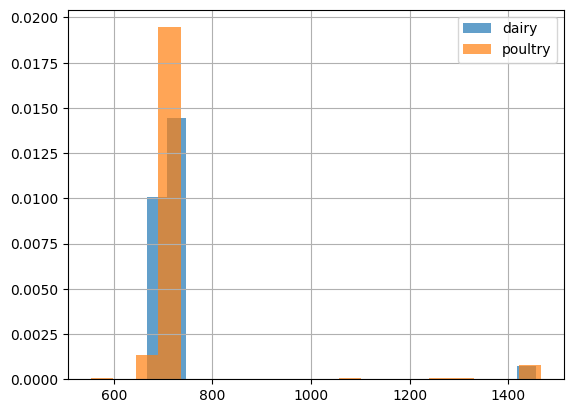

In [11]:
farm_info_df.groupby("type").average_revisit.\
    hist(bins=20, density=True, alpha=0.7, legend=True)
plt.show()

=> Clearly there are outliers with revisit time

Let's look at the histogram without these outliers:

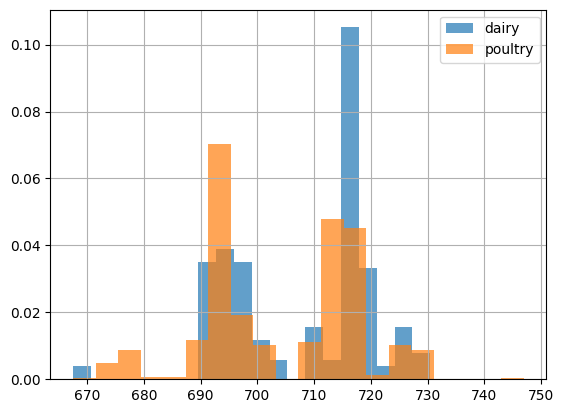

In [12]:
farm_info_df.\
    where(farm_info_df.average_revisit < 800).\
    where(farm_info_df.average_revisit > 600).\
    groupby("type").\
    average_revisit.hist(bins=20, density=True, alpha=0.7, legend=True)
plt.show()

And what how many farms do we lose if we drop them?

In [13]:
print(f"Total farms (poultry, dairies): {len(farm_info_df)} ({len(poultry)}, {len(dairies)})")

tm =  sum(farm_info_df.average_revisit > 800)
tm_poultry = sum(farm_info_df.where(farm_info_df.type == "poultry").average_revisit > 800)
tm_dairy = sum(farm_info_df.where(farm_info_df.type == "dairy").average_revisit > 800)
print(f"Farms (poultry, dairies) with average revisit time > 800 days: {tm} ({tm_poultry}, {tm_dairy})")

tl = sum(farm_info_df.average_revisit < 600)
tl_poultry = sum(farm_info_df.where(farm_info_df.type == "poultry").average_revisit < 600)
tl_dairy = sum(farm_info_df.where(farm_info_df.type == "dairy").average_revisit < 600)
print(f"Farms (poultry, dairies) with average revisit time < 600 days: {tl} ({tl_poultry}, {tl_dairy})")

Total farms (poultry, dairies): 924 (168, 756)
Farms (poultry, dairies) with average revisit time > 800 days: 38 (33, 5)
Farms (poultry, dairies) with average revisit time < 600 days: 3 (3, 0)


### When are the images from?

In [14]:
poultry_dates = [date.year for dates in naip_poultry_all_dates.values() for date in dates]
dairy_dates = [date.year for dates in naip_dairy_all_dates.values() for date in dates]

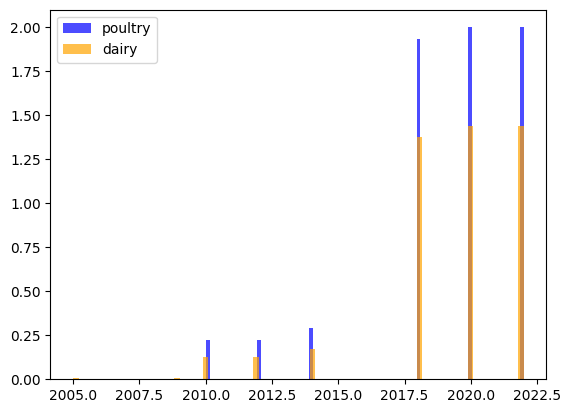

In [15]:
# densities for dates
plt.hist(poultry_dates, bins=80, density=True, alpha=0.7, color='blue')
plt.hist(dairy_dates, bins=80, density=True, alpha=0.7, color='orange')
plt.legend(["poultry", "dairy"])
plt.show()

In [16]:
print(np.unique(poultry_dates, return_counts=True))
print(np.unique(dairy_dates, return_counts=True))

(array([2010, 2012, 2014, 2018, 2020, 2022]), array([ 17,  17,  22, 146, 151, 151]))
(array([2005, 2009, 2010, 2012, 2014, 2016, 2018, 2019, 2020, 2022]), array([  4,   3,  60,  62,  84,   2, 663,   2, 694, 694]))


Data is inconsistent over time. We don't have every year!

THere are also some years with very few images (e.g., 4 images from 2005 for dairies).

## PlanetScope

### Basic stats

In [17]:
print("Number of farms in PS: ", len(ps_top20_dates.keys()))

Number of farms in PS:  40


In [18]:
[x for x in ps_top20_dates.keys() if x not in top20]

[]

We have complete overlap with the top 20 farms in NAIP, but this is the only data we have.

### Average revisit time and number of images

In [19]:
farm_info_pss = {
    idx : {
        "type" : "poultry" if idx in dairies else "dairy",
        "num_images": len(dates),
        "average_revisit": np.mean([(dates[i] - dates[i-1]).days for i in range(1, len(dates))]),
        "earliest_date": dates[0],
        "latest_date": dates[-1]
    }
    for idx, dates in ps_top20_dates.items()
}

In [20]:
farm_info_pss_df = pd.DataFrame.from_dict(farm_info_pss, orient='index')
farm_info_pss_df.head()

,type,num_images,average_revisit,earliest_date,latest_date
1203,poultry,15,104.714286,2019-04-09,2023-04-14
1779,poultry,12,100.000000,2019-04-10,2022-04-14
1979,dairy,8,157.142857,2019-04-10,2022-04-14
2181,poultry,19,81.444444,2019-04-09,2023-04-14
2286,dairy,12,99.454545,2019-04-13,2022-04-11


In [30]:
farm_info_pss_df[["type", "num_images", "average_revisit"]].\
    groupby("type").\
    aggregate(["min", "max", 'mean', 'median', 'std'])

num_images                                 average_revisit         \
               min max       mean median       std             min    max   
type                                                                        
dairy            2  19  11.642857   12.5  5.293002             1.0  219.8   
poultry          2  21  11.916667   12.5  5.728054             1.0  146.4   

                                            
               mean      median        std  
type                                        
dairy    106.915875   94.612500  49.076157  
poultry   97.464000  102.357143  36.647653

We have much more variation in the number of images per farm, and the revisit time is shorter.

But actually, PS images are once a year, there are just several images in this weekly window.

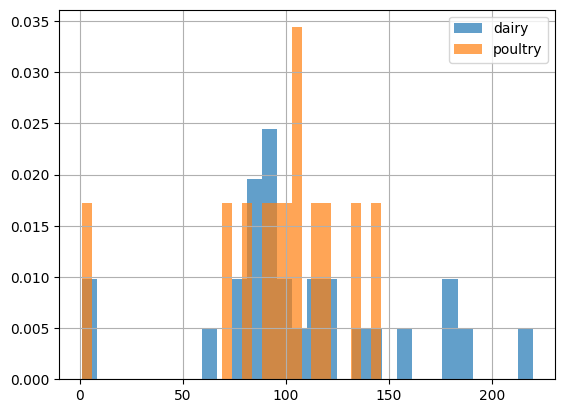

In [22]:
farm_info_pss_df.groupby("type").average_revisit.\
    hist(bins=30, density=True, legend=True, alpha=0.7)
plt.show()

There are less clear outliers here, but the average revisit time varies a lot.

### When are the images from?

In [23]:
poultry_dates_pss = [date.year for idx, dates in ps_top20_dates.items() 
                     for date in dates 
                     if idx in naip_poultry_all_dates.keys()]
dairy_dates_pss = [date.year for idx, dates in ps_top20_dates.items()
                     for date in dates
                     if idx in naip_dairy_all_dates.keys()]

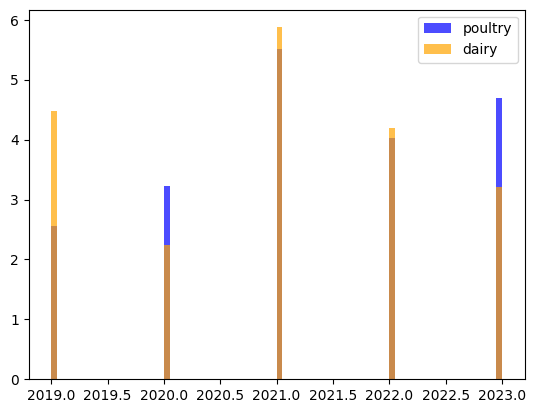

In [24]:
# densities for dates
plt.hist(poultry_dates_pss, bins=80, density=True, alpha=0.7, color='blue')
plt.hist(dairy_dates_pss, bins=80, density=True, alpha=0.7, color='orange')
plt.legend(["poultry", "dairy"])
plt.show()

In [25]:
print(np.unique(poultry_dates_pss, return_counts=True))
print(np.unique(dairy_dates_pss, return_counts=True))

(array([2019, 2020, 2021, 2022, 2023]), array([19, 24, 41, 30, 35]))
(array([2019, 2020, 2021, 2022, 2023]), array([32, 16, 42, 30, 23]))


Data is more consistent over yearly time - every year from 2019 to 2023.